# Stage 4: Intervention design

In this tutorial, we'll walk through how to use the CASCADE model trained in
[stage 2](training.ipynb) to perform targeted intervention design, using
K562-to-erythroid differentiation as an example.

In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.sparse import csr_matrix

from cascade.data import (
    configure_dataset,
    encode_regime,
    get_all_targets,
    get_configuration,
)
from cascade.model import CASCADE, IntervDesign
from cascade.plot import plot_design_error_curve, plot_design_scores, set_figure_params

In [2]:
set_figure_params()

## Prepare source data

First, we will extract the source state, i.e., unperturbed K562 cells from our
preprocessed data:

In [3]:
adata = sc.read_h5ad("adata.h5ad")
adata

AnnData object with n_obs × n_vars = 86744 × 1064
    obs: 'guide_id', 'gemgroup', 'ncounts', 'knockup'
    var: 'perturbed', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'selected'
    uns: '__CASCADE__', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'covariate'
    varm: 'PCs'
    layers: 'counts', 'interv'

In [4]:
source = adata[adata.obs["knockup"] == ""].copy()
source

AnnData object with n_obs × n_vars = 11855 × 1064
    obs: 'guide_id', 'gemgroup', 'ncounts', 'knockup'
    var: 'perturbed', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'selected'
    uns: '__CASCADE__', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'covariate'
    varm: 'PCs'
    layers: 'counts', 'interv'

## Prepare target data

Next, we use an erythroid scRNA-seq dataset from
[Xu, et al. (2022)](https://doi.org/10.1038/s41590-022-01245-8) as the
target state. The data file can be downloaded from here:

- http://ftp.cbi.pku.edu.cn/pub/cascade-download/Xu-2022.h5ad

In [5]:
target = sc.read_h5ad("Xu-2022.h5ad")
target

AnnData object with n_obs × n_vars = 74460 × 27069
    obs: 'Clusters', 'batch', 'stage', 'ncounts'

Some genes in our source dataset could be missing from the target data, so we
manually expand the target data with zero-paddings:

In [6]:
common_vars = [i for i in adata.var_names if i in target.var_names]
missing_vars = [i for i in adata.var_names if i not in target.var_names]
len(common_vars), len(missing_vars)

(930, 134)

In [7]:
empty = ad.AnnData(
    X=csr_matrix((target.n_obs, len(missing_vars)), dtype=target.X.dtype),
    obs=target.obs,
    var=pd.DataFrame(index=missing_vars),
)
target = ad.concat([target, empty], axis=1, merge="first")
target

AnnData object with n_obs × n_vars = 74460 × 27203
    obs: 'Clusters', 'batch', 'stage', 'ncounts'

Similar to the training data, we backup the raw counts and log-normalize the
dataset.

In [8]:
target.layers["counts"] = target.X.copy()
sc.pp.normalize_total(target, target_sum=1e4)
sc.pp.log1p(target)

We'd also need to configure the target dataset. Of note, the target data
configuration should provide the same covariate as the training data. However,
it obviously does not have batch info compatible with the training data.

Here we are using a rough approach of simply taking the covariate
of random training cells. Another possibility is to take the covariate of
training cells most similar to the target cells, based on the expression levels
of housekeeping genes.

In [9]:
target.obsm["covariate"] = source.obsm["covariate"][
    np.random.choice(source.n_obs, target.n_obs)
]

In [10]:
configure_dataset(
    target, use_covariate="covariate", use_size="ncounts", use_layer="counts"
)
get_configuration(target)

{'regime': None,
 'covariate': 'covariate',
 'size': 'ncounts',
 'weight': None,
 'layer': 'counts'}

## Define gene weights

Given that the source and target data were produced with different experimental
protocols in different studies, batch effect would be a substantial problem.
To mitigate this issue, we give higher weight to known erythroid markers when
comparing counterfactual states with the target state during intervention
design, which helps avoid learning batch effect between source and target.

In [11]:
markers = [
    "AHSP",
    "ALAS2",
    "ALDOA",
    "BLVRB",
    "BPGM",
    "CLIC1",
    "ENO1",
    "GYPA",
    "GYPB",
    "HAMP",
    "HBA1",
    "HBA2",
    "HBB",
    "HBD",
    "HBE1",
    "HBG1",
    "HBG2",
    "HBZ",
    "HEMGN",
    "LDHA",
    "PRDX1",
    "PRDX2",
    "SLC25A37",
    "SLC4A1",
    "SMIM1",
]
assert not set(markers) - set(adata.var_names)
assert not set(markers) - set(target.var_names)
len(markers)

25

In [12]:
non_markers = [i for i in common_vars if i not in markers]
len(non_markers)

905

In [13]:
target.var["weight"] = 0.0
target.var.loc[non_markers, "weight"] = len(common_vars) / len(non_markers) / 2
target.var.loc[markers, "weight"] = len(common_vars) / len(markers) / 2

In [14]:
target.var.loc[non_markers, "weight"].head()

SAMD11     0.513812
HES4       0.513812
ISG15      0.513812
RNF223     0.513812
TNFRSF4    0.513812
Name: weight, dtype: float64

In [15]:
target.var.loc[markers, "weight"].head()

AHSP     18.6
ALAS2    18.6
ALDOA    18.6
BLVRB    18.6
BPGM     18.6
Name: weight, dtype: float64

In this case we scaled the gene weights so that the total weight of marker genes
equals and the total weight of non-marker genes, and genes that were zero-padded
in the target data were given zero weight, so they will not bias the result.

## Specify candidate genes

We can also provide a candidate gene pool, e.g., we'll just use genes perturbed
in the CRISPRa dataset that show higher expression in the target cells:

In [16]:
all_targets = sorted(get_all_targets(adata, "knockup"))
target_mask = (
    target[:, all_targets].to_df().mean() > adata[:, all_targets].to_df().mean()
)
candidates = target_mask.index[target_mask].to_list()
candidates

['ARRDC3',
 'ATL1',
 'BPGM',
 'CDKN1A',
 'CDKN1B',
 'CDKN1C',
 'CEBPA',
 'CEBPB',
 'COL1A1',
 'CSRNP1',
 'EGR1',
 'ETS2',
 'FOSB',
 'FOXF1',
 'HNF4A',
 'HOXA13',
 'IER5L',
 'IGDCC3',
 'IRF1',
 'JUN',
 'KLF1',
 'MAML2',
 'MAP2K3',
 'MAP2K6',
 'MAP3K21',
 'MAP4K5',
 'MEIS1',
 'MIDEAS',
 'PRDM1',
 'PRTG',
 'PTPN13',
 'RUNX1T1',
 'SGK1',
 'SLC38A2',
 'SLC4A1',
 'SNAI1',
 'SPI1',
 'TBX3',
 'TGFBR2',
 'TSC22D1',
 'ZBTB1',
 'ZBTB10']

## Run intervention design

> (Estimated time: 10 min – 20 min, depending on computation device)

Finally, we can load our trained model for intervention design:

In [17]:
cascade = CASCADE.load("tune.pt")

For the sake of speed, we will subsample both the source and target data to
5,000 cells.

In [18]:
sc.pp.subsample(source, n_obs=5000)
sc.pp.subsample(target, n_obs=5000)

CASCADE model provides a dedicated [design](api/cascade.model.CASCADE.design.rst)
method for intervention design, which uses differentiable optimization to
optimize interventions that produces effects more similar to the target state.

We'll need to pass the source and target datasets, along with a candidate gene
pool, a maximal combination order (`design_size=1` for designing single-gene
perturbations), as well as the target gene weight we just assigned.

In [19]:
scores, design = cascade.design(
    source, target, pool=candidates, design_size=1, target_weight="weight"
)

17:32:38.143 | WARNING  | 3810563:model:align_vars - 26139 variables are not in the `scaffold` and will thus be ignored.


17:32:38.151 | INFO     | 3810563:utils:autodevice - Using GPU [1] as computation device.


╭────────────────────────────── cascade-reg ──────────────────────────────╮
│                                                                         │
│  Training on 1064 variables with 12294 scaffold edges and 5000 samples  │
│                                                                         │
╰──────────────────────────────── v0.4.0 ─────────────────────────────────╯

17:32:38.325 | INFO     | 3810563:core:fit_stage - Number of topological generations: [68, 88, 70, 101]



  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | scaffold     | Edgewise     | 49.2 K | eval 
1 | sparse       | L1           | 0      | eval 
2 | acyc         | SpecNorm     | 0      | eval 
3 | kernel       | RBF          | 0      | eval 
4 | latent       | EmbLatent    | 6.3 K  | eval 
5 | lik          | NegBin       | 0      | eval 
6 | func         | Func         | 7.9 M  | eval 
7 | design       | IntervDesign | 8.6 K  | train
  | other params | n/a          | 8.5 K  | n/a  
------------------------------------------------------
10.7 K    Trainable params
8.0 M     Non-trainable params
8.0 M     Total params
31.955    Total estimated model params size (MB)
1         Modules in train mode
16        Modules in eval mode


Training: |                                                                                                   …

Restoring best model: log_dir/design/lightning_logs/version_0/checkpoints/epoch=8-step=1200.ckpt.

The `design` method returns two objects:

- The `scores` object is a data frame containing scores of candidate genes
  (or gene combinations if `design_size` was larger than 1).
- The `design` object is an [IntervDesign](api/cascade.nn.IntervDesign.rst)
  module that contains both the scores and optimized interventional scales and
  biases for the designed interventions, which can also be saved and loaded just
  like the CASCADE model.

In [20]:
scores.to_csv("design.csv")
scores.head()

,score
KLF1,10.006369
BPGM,4.527291
ATL1,2.883361
PTPN13,1.928048
ARRDC3,-0.666598


In [21]:
design.save("design.pt")
design = IntervDesign.load("design.pt")

The same can also be achieved using the
[command line interface](cli.rst#intervention-design)
with the following command.

```sh
cascade design -d source.h5ad -m tune.pt -t target.h5ad \
    --pool candidates.txt -o design.csv -u design.pt \
    --design-size 1 --target-weight weight [other options]
```

## Determine design score cutoff

In [22]:
curve, cutoff = cascade.design_error_curve(source, target, design, n_cells=5000)

18:02:56.569 | WARNING  | 3810563:model:align_vars - 26139 variables are not in the `scaffold` and will thus be ignored.
/rd1/user/caozj/CASCADE/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/rd1/user/caozj/CASCADE/conda/lib/python3.11/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['ATTCTACAGCGTCAAG-1', 'CTTCTCTCATCGACGC-1', 'TACGGATGTGATGTCT-1', 'AGCCTAAAGAAACCTA-1', 'AACTCAGAGCTCCCAG-1']
  warnings.warn(


18:03:00.430 | INFO     | 3810563:core:predict_mode - Number of topological generations: [68, 88, 70, 101]


Predicting: |                                                                                                 …

<Axes: xlabel='Design score', ylabel='MSE estimate'>

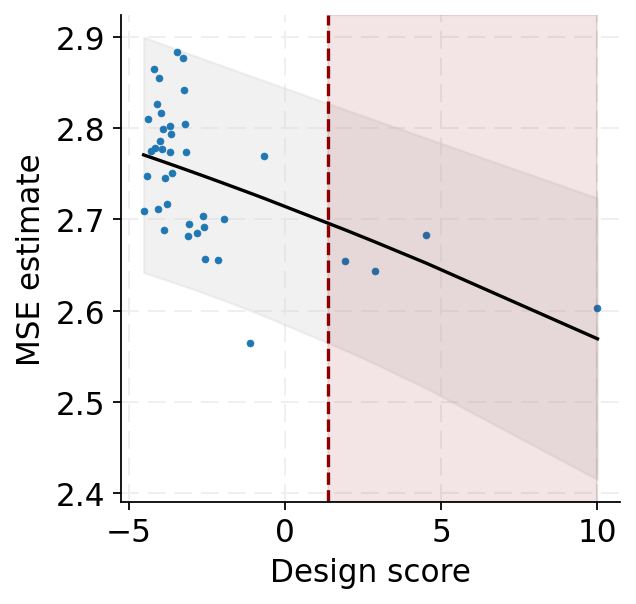

In [23]:
plot_design_error_curve(curve, cutoff=cutoff)

We can also visualize the scores with a scatter plot:

<Axes: xlabel='Design rank', ylabel='Design score'>

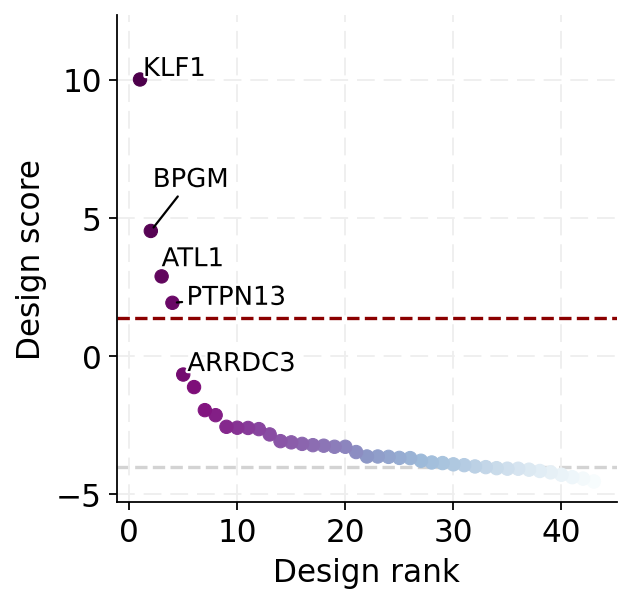

In [24]:
plot_design_scores(scores, cutoff=cutoff)

## Verify design with counterfactual prediction

The designed perturbation can certainly be passed back to the
[counterfactual](api/cascade.model.CASCADE.counterfactual.rst) method to verify
whether the target markers are up-regulated, just like what we did in
[stage 3](counterfactual.ipynb).

One notable difference is that we need to specify the `design` argument of the
[counterfactual](api/cascade.model.CASCADE.counterfactual.rst) method, which
tells the model to use the designed interventional scales and biases
(instead of those from the training set) when making counterfactual
predictions.

In [25]:
source.obs["my_pert"] = "KLF1"
encode_regime(source, "ctfact", key="my_pert")

18:07:48.121 | WARNING  | 3810563:data:encode_regime - Overwriting existing regime "ctfact".


In [26]:
configure_dataset(source, use_regime="ctfact")
ctfact = cascade.counterfactual(source, design=design, sample=True)

18:07:48.188 | WARNING  | 3810563:data:configure_dataset - Overwriting existing `regime` = "interv".


18:07:48.370 | INFO     | 3810563:core:predict_mode - Number of topological generations: [68, 88, 70, 101]


Predicting: |                                                                                                 …

In [27]:
configure_dataset(source, use_regime="interv")
nil = cascade.counterfactual(source, design=design, sample=True)

18:07:56.710 | WARNING  | 3810563:data:configure_dataset - Overwriting existing `regime` = "ctfact".


18:07:57.178 | INFO     | 3810563:core:predict_mode - Number of topological generations: [68, 88, 70, 101]


Predicting: |                                                                                                 …

In [28]:
combined = ad.concat({"nil": nil, "ctfact": ctfact}, label="role", index_unique="-")
combined.X = np.log1p(combined.X * (1e4 / combined.obs[["ncounts"]].to_numpy()))
combined

AnnData object with n_obs × n_vars = 10000 × 1064
    obs: 'guide_id', 'gemgroup', 'ncounts', 'knockup', 'my_pert', 'role'
    obsm: 'X_pca', 'covariate'
    layers: 'counts', 'interv', 'ctfact', 'X_ctfact'

In [29]:
sc.tl.rank_genes_groups(combined, "role", reference="nil", rankby_abs=True, pts=True)
de_df = sc.get.rank_genes_groups_df(combined, "ctfact").query("pct_nz_group > 0.05")
de_df["-logfdr"] = -np.log10(de_df["pvals_adj"]).clip(lower=-350)
de_df["is_marker"] = de_df["names"].isin(markers)
de_df.head()

/rd1/user/caozj/CASCADE/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,-logfdr,is_marker
0,KLF1,492.331299,2.114285,0.0,0.0,1.0,350.0,False
1,PNMT,438.697296,2.480975,0.0,0.0,1.0,350.0,False
2,TMSB10,366.669769,1.523769,0.0,0.0,1.0,350.0,False
3,S100A10,247.035904,1.381347,0.0,0.0,1.0,350.0,False
4,HBG2,236.489166,1.407301,0.0,0.0,1.0,350.0,True


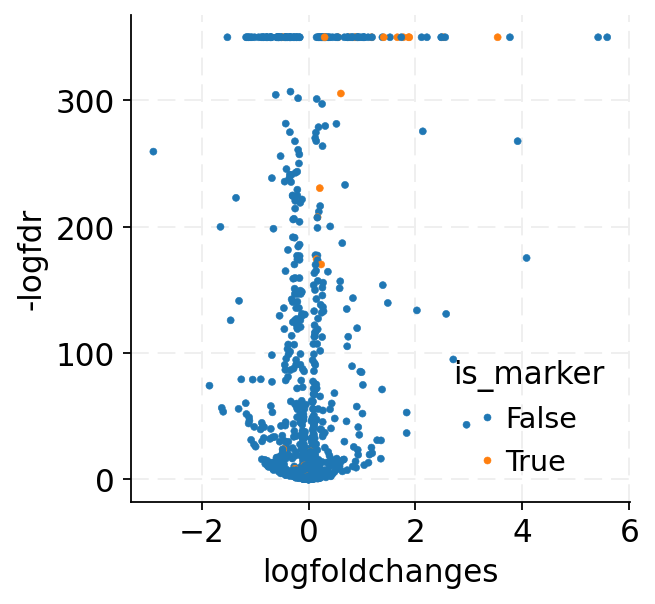

In [30]:
_ = sns.scatterplot(
    data=de_df, x="logfoldchanges", y="-logfdr", hue="is_marker", edgecolor=None, s=10
)